# Comprehensive Time Series Sequence Analysis for Retail Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

## Generating Synthetic Retail Data

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Create date range for 3 years of daily data
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize dataframe
df = pd.DataFrame({'date': date_range})
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

# Base sales with trend
df['base_sales'] = np.linspace(1000, 1500, len(df))  # Upward trend

# Add weekly pattern (weekends have higher sales)
weekly_pattern = np.array([0.85, 0.8, 0.9, 0.9, 1.0, 1.2, 1.3])
df['weekly_effect'] = df['dayofweek'].apply(lambda x: weekly_pattern[x])

# Add monthly seasonality
monthly_pattern = np.array([0.8, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.1, 1.0, 1.05, 1.2, 1.4])  # December holiday spike
df['monthly_effect'] = df['month'].apply(lambda x: monthly_pattern[x-1])

# Add holiday effects
holidays = {
    # Format: ((month, day), multiplier)
    (1, 1): 0.8,    # New Year's Day
    (7, 4): 1.2,    # Independence Day
    (11, 25): 1.5,  # Black Friday (approx)
    (12, 24): 1.6,  # Christmas Eve
    (12, 25): 0.5,  # Christmas Day
    (12, 31): 1.3,  # New Year's Eve
}

df['holiday_effect'] = 1.0
for (month, day), multiplier in holidays.items():
    holiday_mask = (df['month'] == month) & (df['day'] == day)
    df.loc[holiday_mask, 'holiday_effect'] = multiplier

# Combine all effects and add noise
df['sales'] = df['base_sales'] * df['weekly_effect'] * df['monthly_effect'] * df['holiday_effect']
df['sales'] = df['sales'] * (1 + np.random.normal(0, 0.05, len(df)))  # Add 5% random noise

# Add some product categories
categories = ['Electronics', 'Clothing', 'Groceries', 'Home Goods', 'Beauty']
category_sales_ratio = {'Electronics': 1.2, 'Clothing': 0.9, 'Groceries': 1.5, 'Home Goods': 0.7, 'Beauty': 0.5}

# Create separate sales columns for each category
for category in categories:
    df[f'{category}_sales'] = df['sales'] * category_sales_ratio[category] * (1 + np.random.normal(0, 0.08, len(df)))

# Set date as index
df.set_index('date', inplace=True)

# Display the first few rows
df.head()

,dayofweek,month,year,day,base_sales,weekly_effect,monthly_effect,holiday_effect,sales,Electronics_sales,Clothing_sales,Groceries_sales,Home Goods_sales,Beauty_sales
date,,,,,,,,,,,,,,
2020-01-01,2,1,2020,1,1000.000000,0.9,0.8,0.8,590.305368,712.822644,617.312011,840.991488,393.132485,341.428782
2020-01-02,3,1,2020,2,1000.456621,0.9,0.8,1.0,715.348979,721.195337,573.603632,1048.297671,484.545729,370.568313
2020-01-03,4,1,2020,3,1000.913242,1.0,0.8,1.0,826.661795,1064.713490,755.286860,1380.710173,546.893295,416.067905
2020-01-04,5,1,2020,4,1001.369863,1.2,0.8,1.0,1034.520646,1275.835926,881.760517,1242.938239,641.165283,518.782427
2020-01-05,6,1,2020,5,1001.826484,1.3,0.8,1.0,1029.701329,1334.296219,958.305833,1702.339148,729.200338,416.645710


## Data Exploration and Visualization

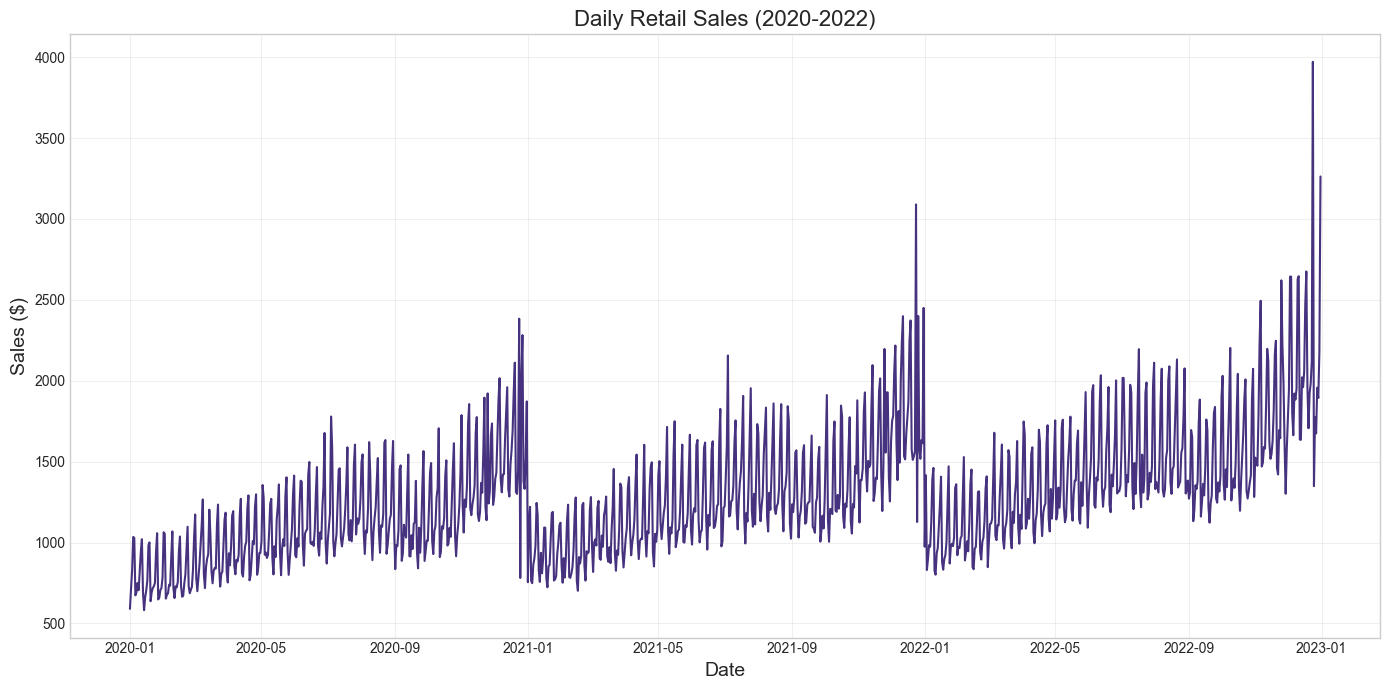

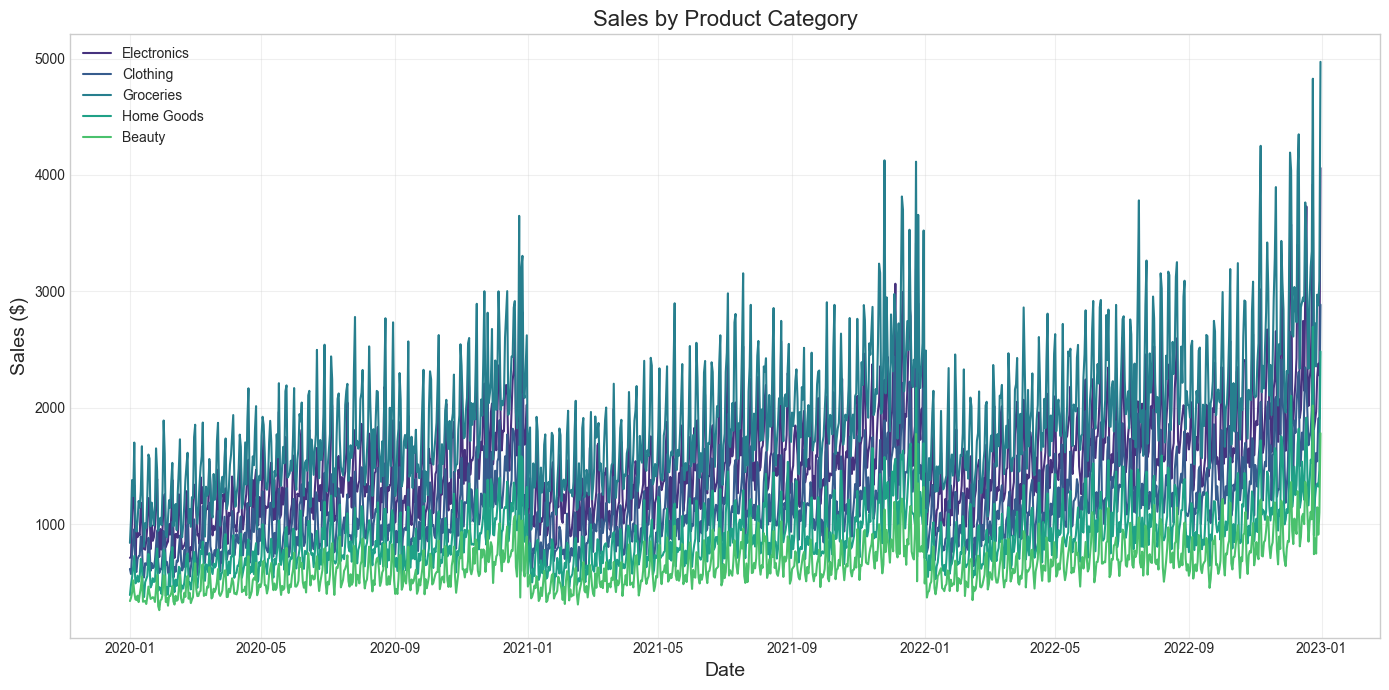

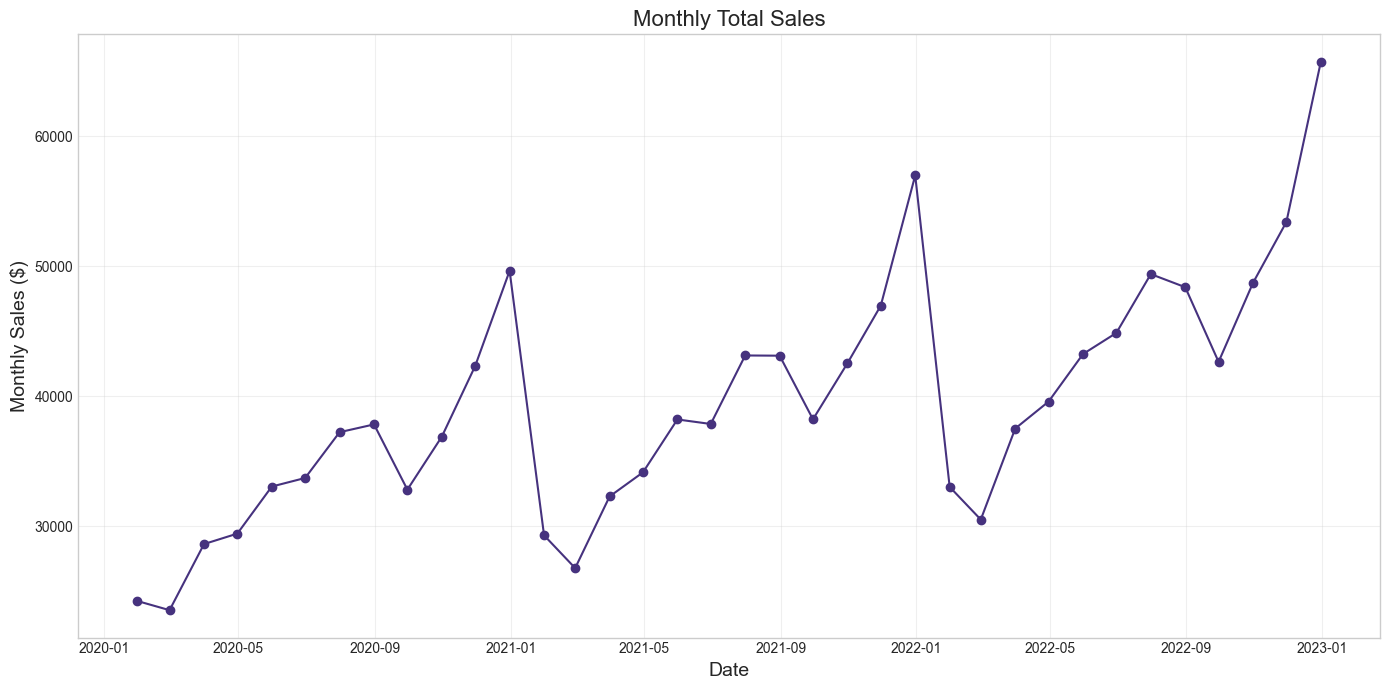

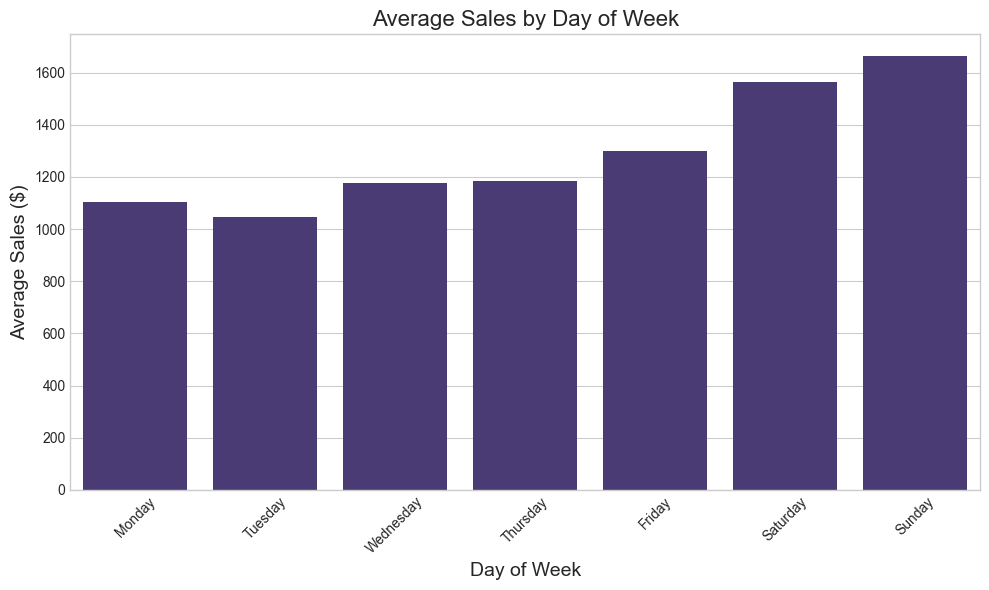

In [3]:
# Plot total sales over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sales'])
plt.title('Daily Retail Sales (2020-2022)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot sales by category
plt.figure(figsize=(14, 7))
for category in categories:
    plt.plot(df.index, df[f'{category}_sales'], label=category)
plt.title('Sales by Product Category', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly aggregation for better pattern visibility
monthly_sales = df['sales'].resample('M').sum()
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, marker='o')
plt.title('Monthly Total Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze day-of-week patterns
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = df.groupby(df.index.dayofweek)['sales'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values)
plt.xticks(ticks=range(7), labels=day_names, rotation=45)
plt.title('Average Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Sales ($)', fontsize=14)
plt.tight_layout()
plt.show()

## Time Series Decomposition

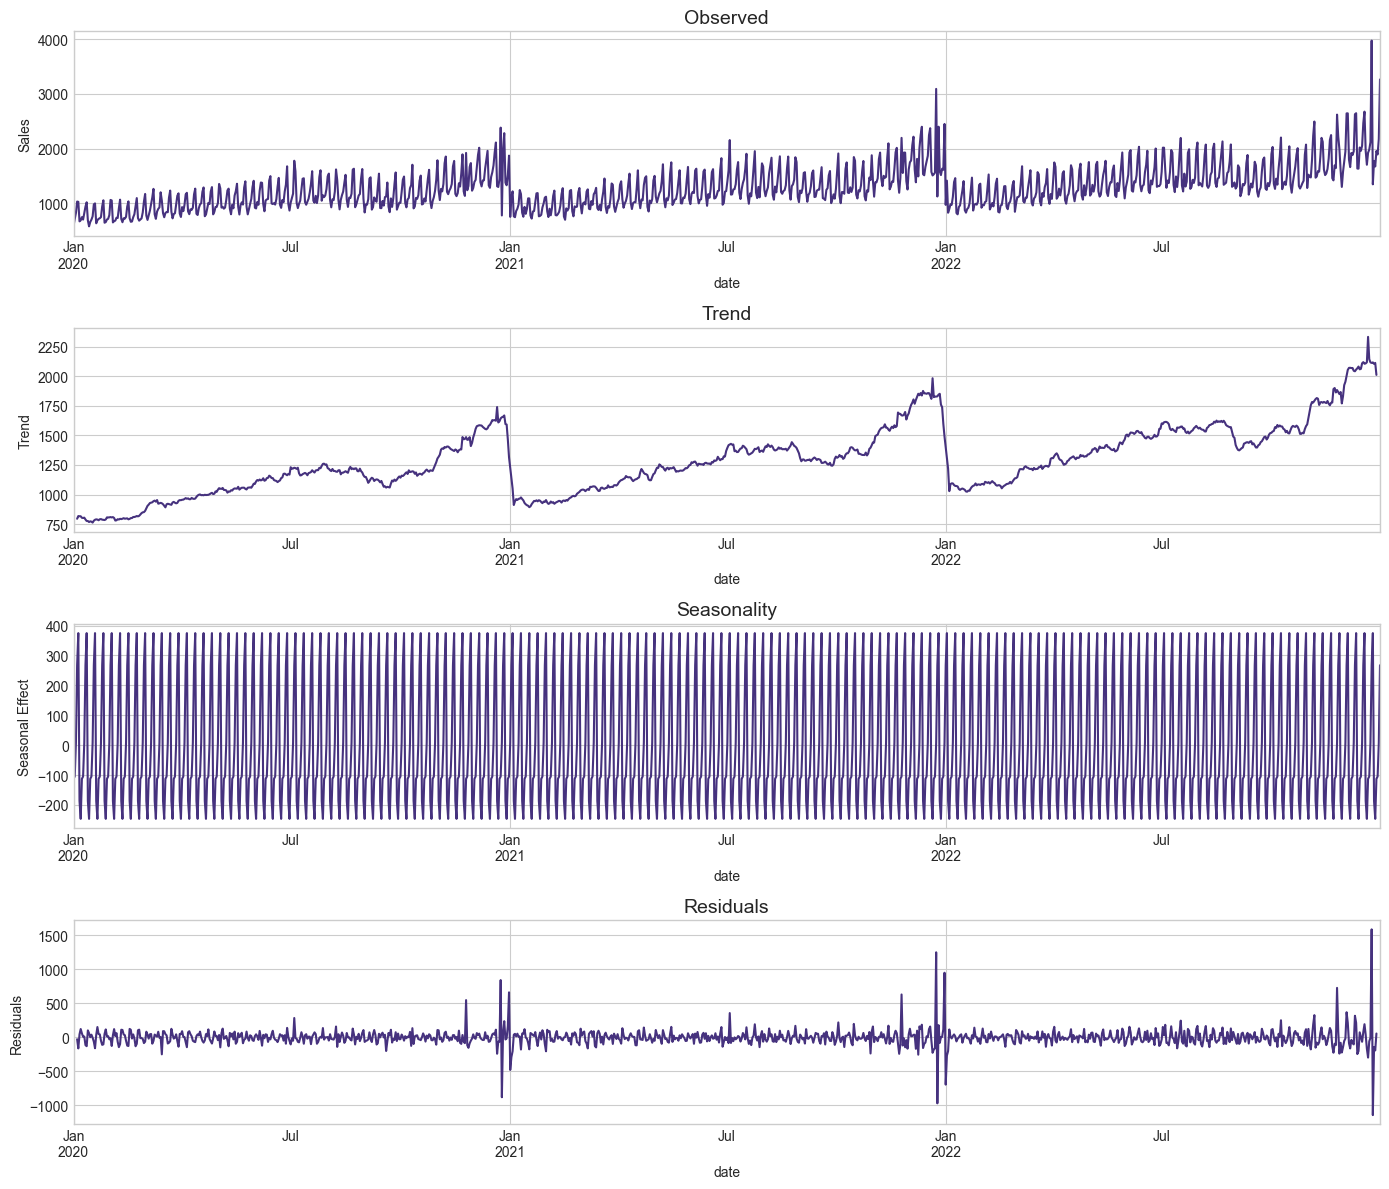

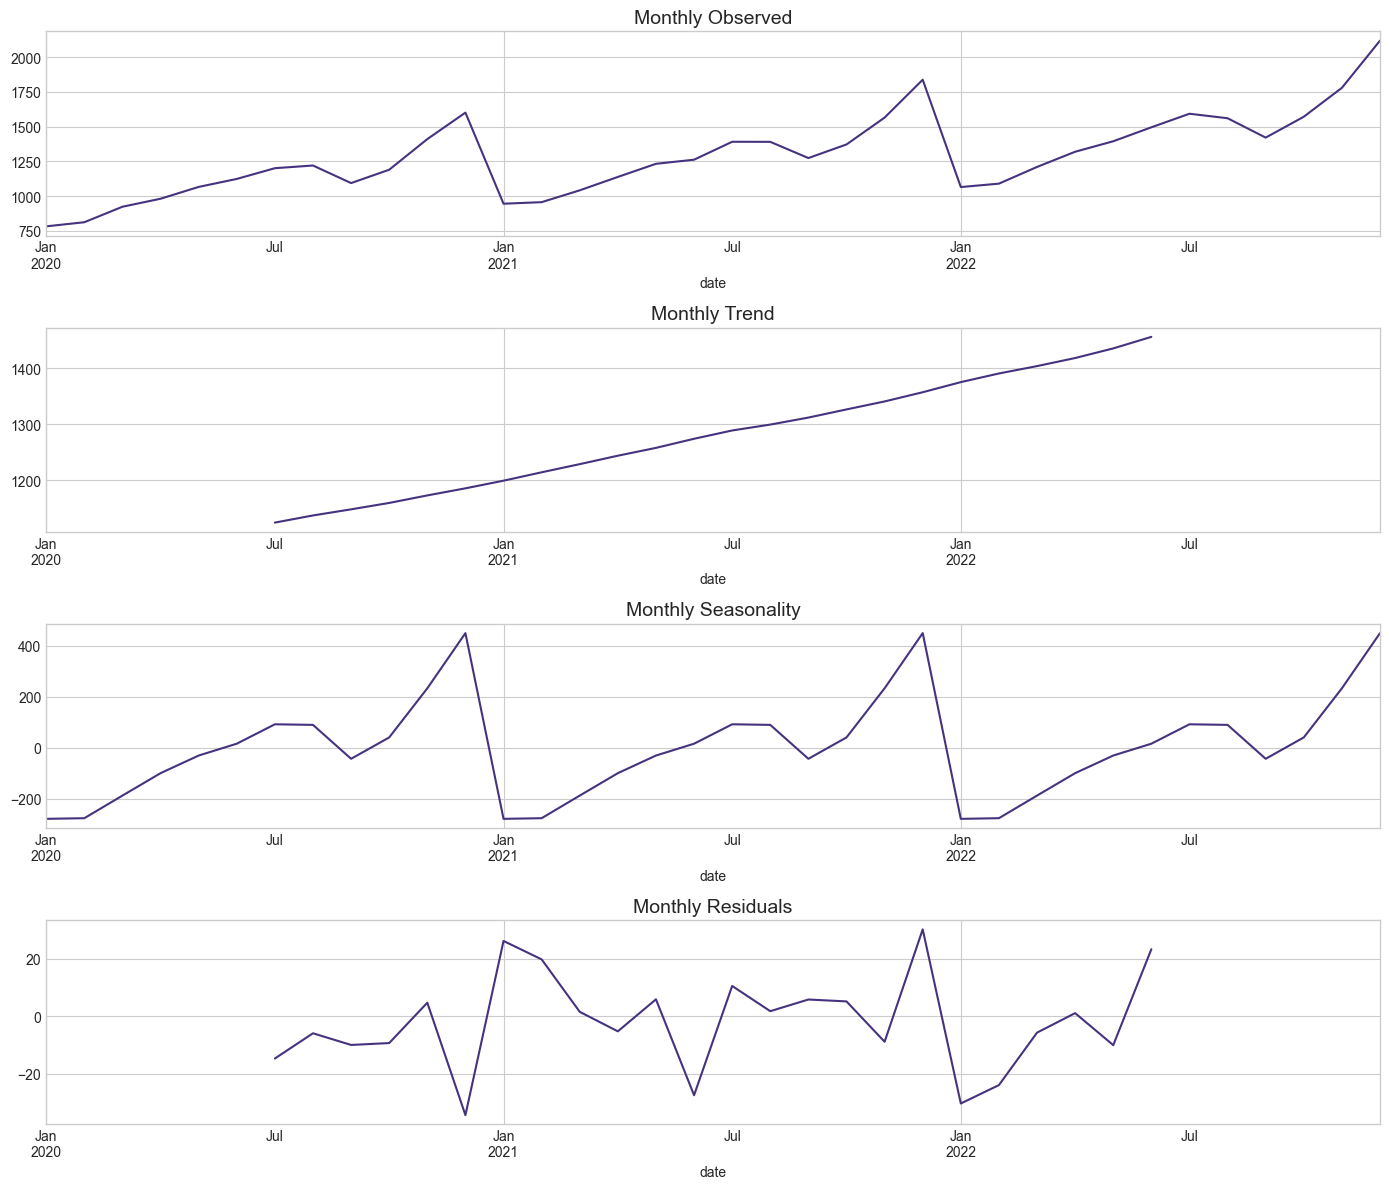

In [4]:
# Use additive decomposition for our dataset
decomposition = seasonal_decompose(df['sales'], model='additive', period=7)

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed', fontsize=14)
ax1.set_ylabel('Sales')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend', fontsize=14)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality', fontsize=14)
ax3.set_ylabel('Seasonal Effect')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals', fontsize=14)
ax4.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# Monthly decomposition
monthly_data = df['sales'].resample('M').mean()
decomposition_monthly = seasonal_decompose(monthly_data, model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

decomposition_monthly.observed.plot(ax=ax1)
ax1.set_title('Monthly Observed', fontsize=14)

decomposition_monthly.trend.plot(ax=ax2)
ax2.set_title('Monthly Trend', fontsize=14)

decomposition_monthly.seasonal.plot(ax=ax3)
ax3.set_title('Monthly Seasonality', fontsize=14)

decomposition_monthly.resid.plot(ax=ax4)
ax4.set_title('Monthly Residuals', fontsize=14)

plt.tight_layout()
plt.show()

## Stationarity Analysis

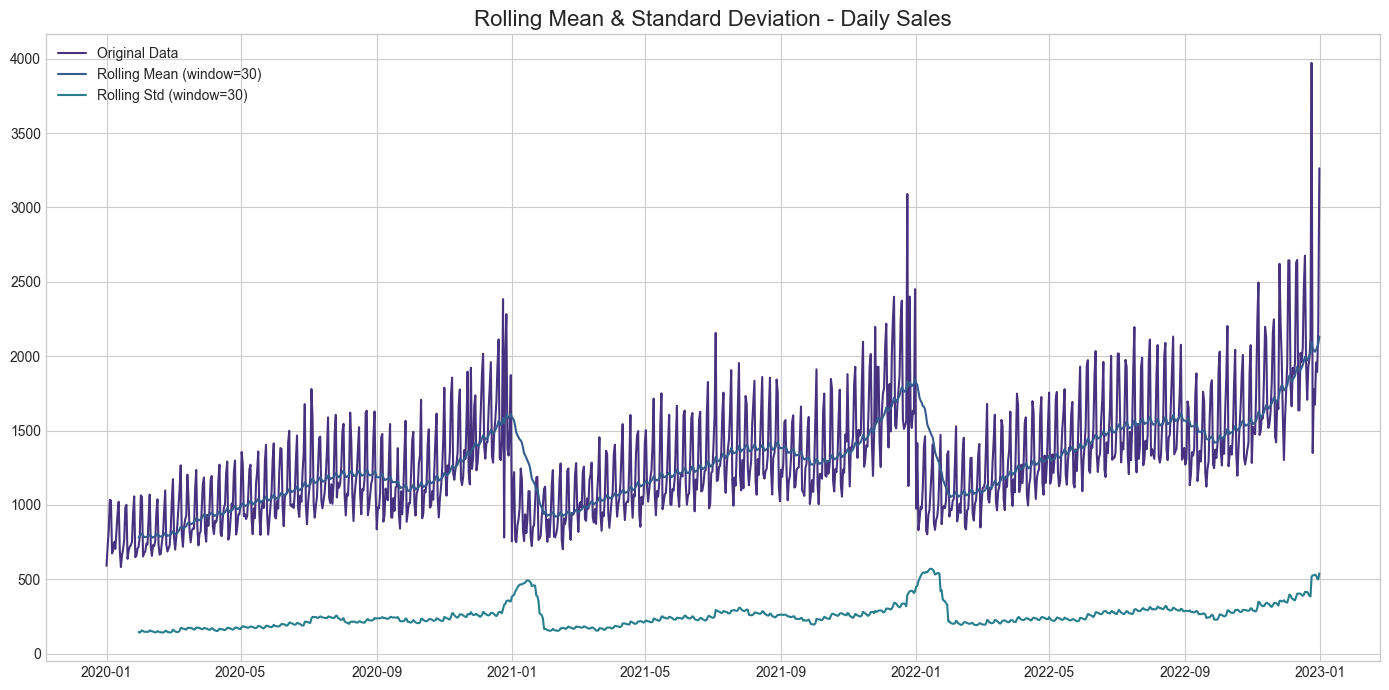

Results of Dickey-Fuller Test for Daily Sales:
Test Statistic                   -1.836303
p-value                           0.362593
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64
Conclusion: Fail to reject the null hypothesis
The series is non-stationary


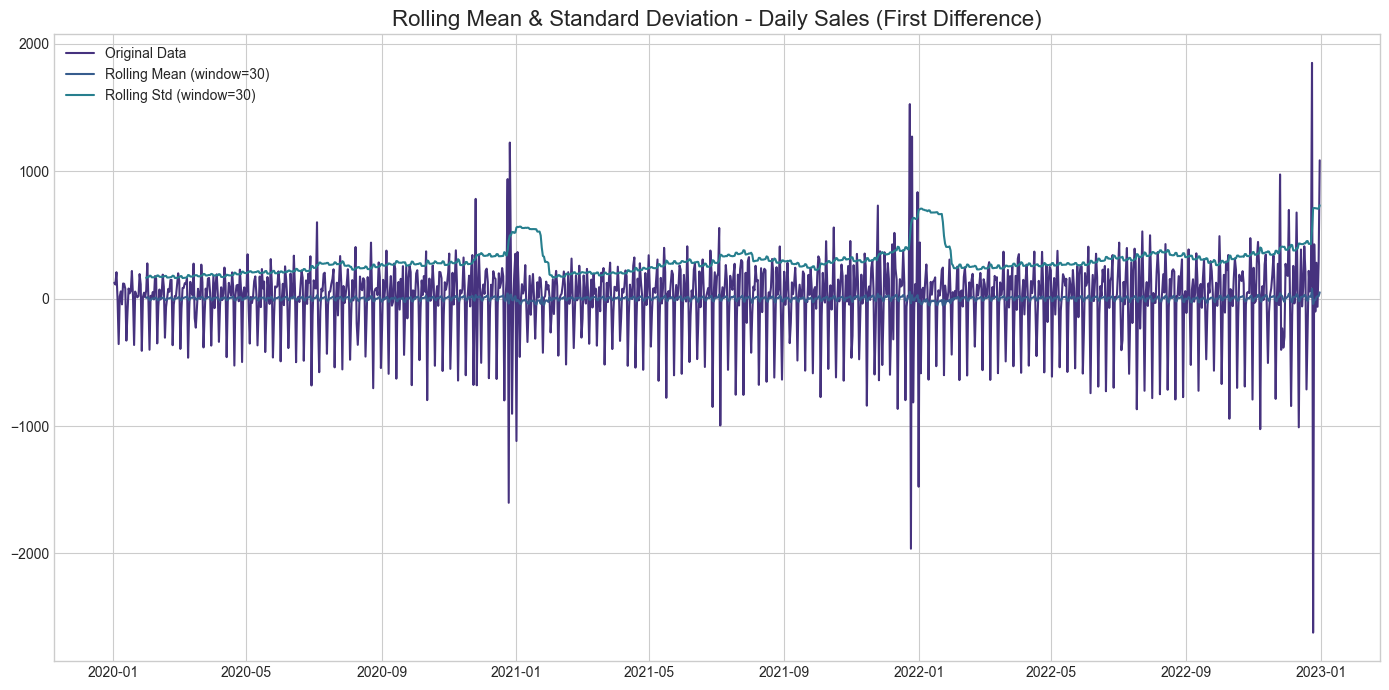

Results of Dickey-Fuller Test for Daily Sales (First Difference):
Test Statistic                -7.394418e+00
p-value                        7.846313e-11
#Lags Used                     2.100000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64
Conclusion: Strong evidence against the null hypothesis
The series is stationary


In [5]:
# Function to test stationarity
def test_stationarity(timeseries, window=12, title=''):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.title(f'Rolling Mean & Standard Deviation - {title}', fontsize=16)
    plt.plot(timeseries, label='Original Data')
    plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std, label=f'Rolling Std (window={window})')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Perform Dickey-Fuller test
    print(f'Results of Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    
    # Interpret the results
    if dftest[1] <= 0.05:
        print("Conclusion: Strong evidence against the null hypothesis")
        print("The series is stationary")
    else:
        print("Conclusion: Fail to reject the null hypothesis")
        print("The series is non-stationary")

# Test stationarity on our daily sales data
test_stationarity(df['sales'], window=30, title='Daily Sales')

# Test stationarity on differenced data
df['sales_diff'] = df['sales'].diff().dropna()
test_stationarity(df['sales_diff'], window=30, title='Daily Sales (First Difference)')

## Autocorrelation Analysis

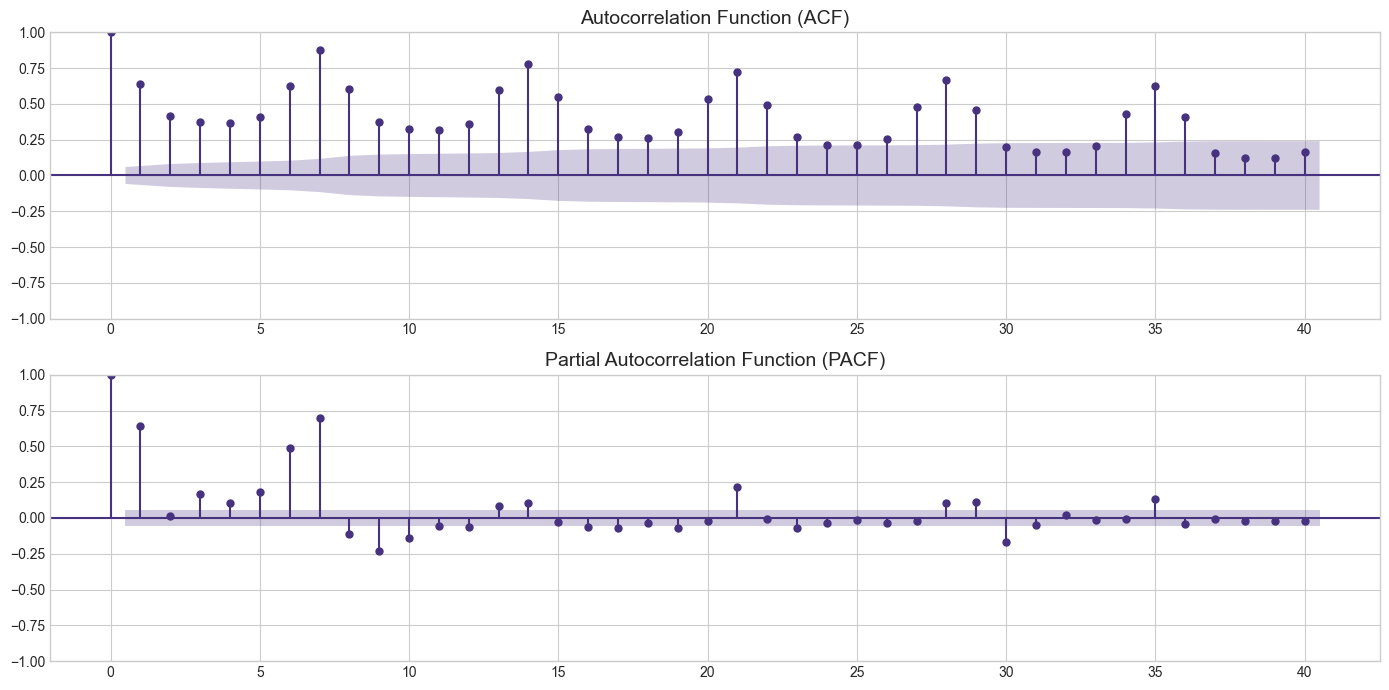

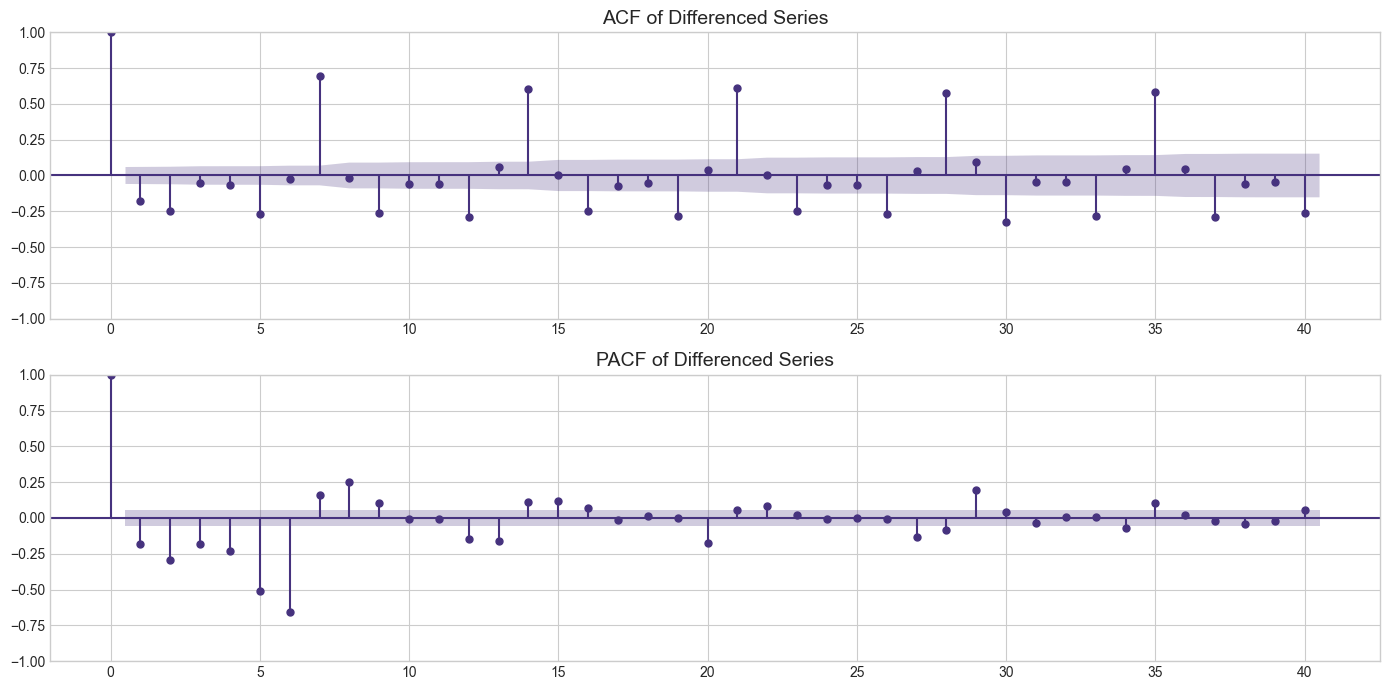

In [6]:
# ACF and PACF plots for original sales
plt.figure(figsize=(14, 7))
plt.subplot(211)
plot_acf(df['sales'].dropna(), ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)', fontsize=14)

plt.subplot(212)
plot_pacf(df['sales'].dropna(), ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)', fontsize=14)
plt.tight_layout()
plt.show()

# ACF and PACF plots for differenced sales
plt.figure(figsize=(14, 7))
plt.subplot(211)
plot_acf(df['sales_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('ACF of Differenced Series', fontsize=14)

plt.subplot(212)
plot_pacf(df['sales_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('PACF of Differenced Series', fontsize=14)
plt.tight_layout()
plt.show()

## ARIMA Modeling and Forecasting

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6980.801
Date:                Mon, 23 Jun 2025   AIC                          13967.603
Time:                        10:16:45   BIC                          13982.341
Sample:                    01-01-2020   HQIC                         13973.203
                         - 10-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.031     10.155      0.000       0.253       0.373
ma.L1         -0.9243      0.015    -61.329      0.000      -0.954      -0.895
sigma2      6.312e+04   2375.394     26.573      0.0

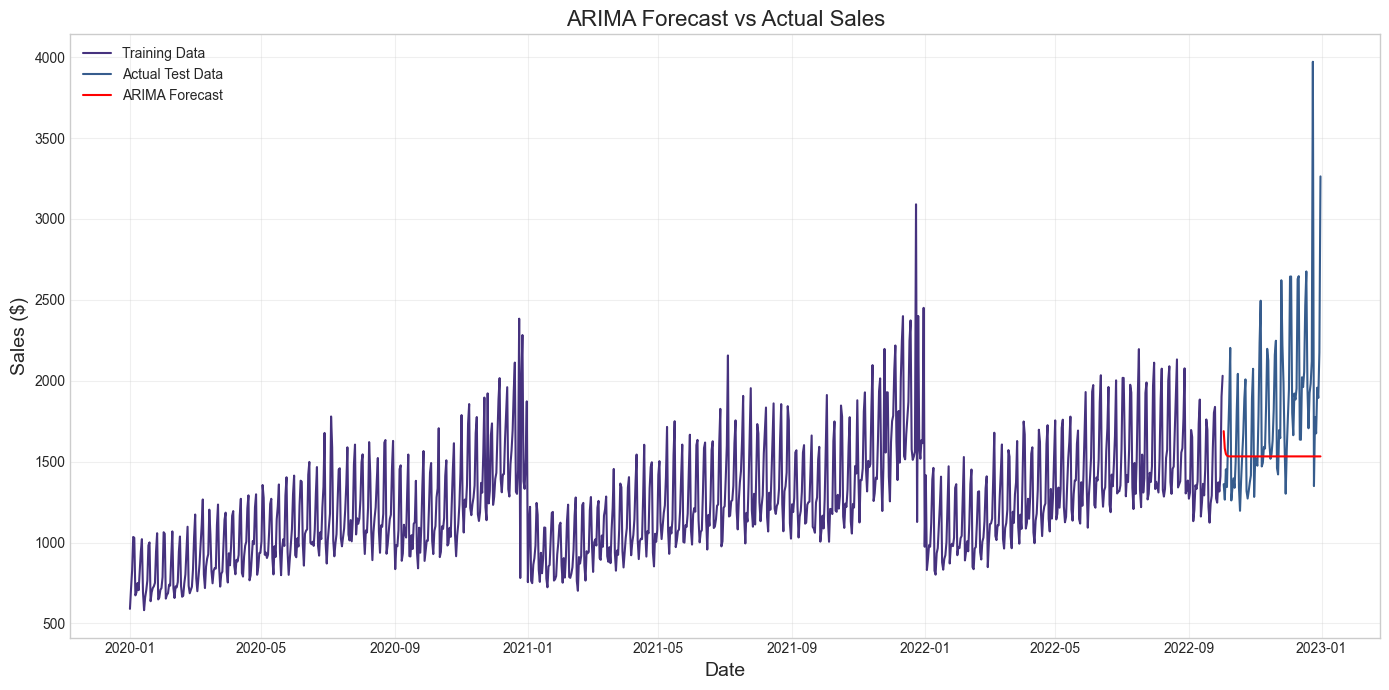

Mean Squared Error: 302299.78
Root Mean Squared Error: 549.82
Mean Absolute Error: 385.26
Mean Absolute Percentage Error: 18.47%


In [7]:
# Prepare data for modeling
train_data = df['sales'].iloc[:-90]  # Use last 90 days as test set
test_data = df['sales'].iloc[-90:]

# Fit ARIMA model (p,d,q) based on ACF/PACF analysis
# Example values: p=1 (from PACF), d=1 (first difference), q=1 (from ACF)
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=90)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

## Exponential Smoothing Models

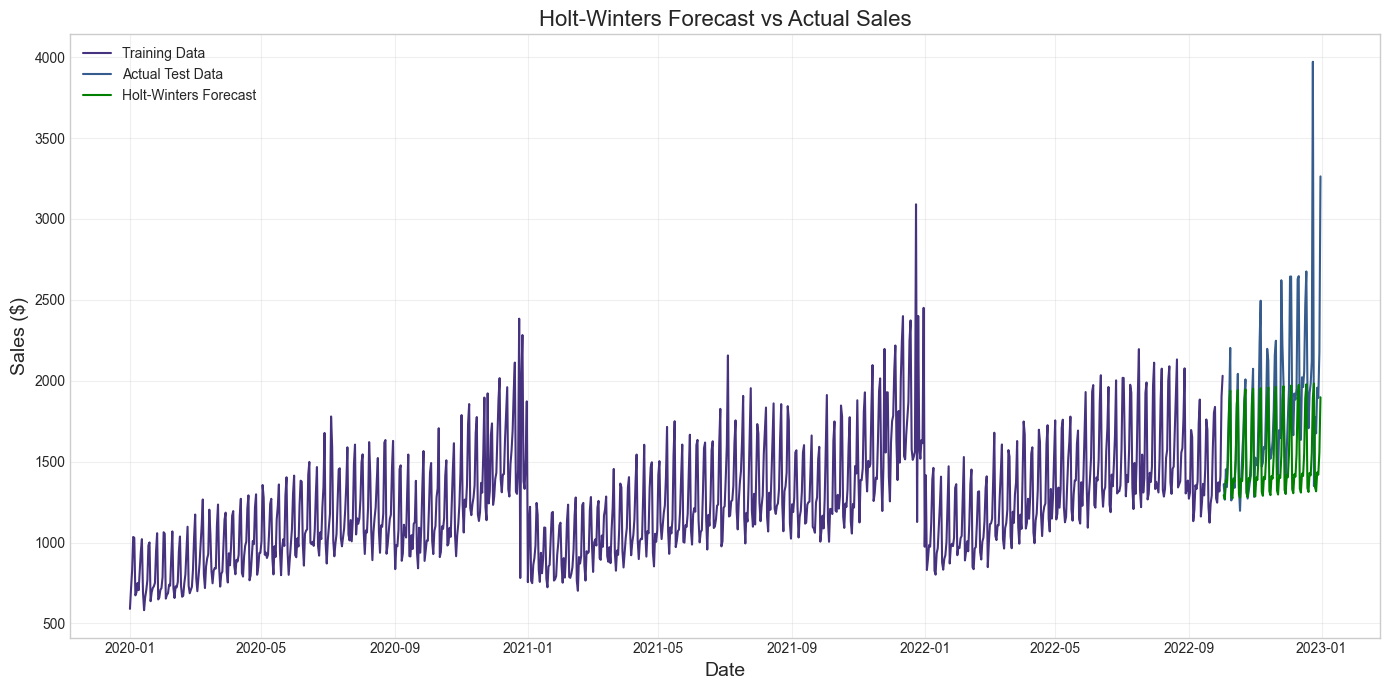

Mean Squared Error: 196085.62
Root Mean Squared Error: 442.82
Mean Absolute Error: 309.78
Mean Absolute Percentage Error: 15.06%


In [8]:
# Fit Holt-Winters' Exponential Smoothing model with seasonality
hw_model = ExponentialSmoothing(
    train_data,
    seasonal_periods=7,
    trend='add',
    seasonal='add'
)
hw_fit = hw_model.fit()

# Forecast
hw_forecast = hw_fit.forecast(90)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Holt-Winters Forecast vs Actual Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error metrics
hw_mse = mean_squared_error(test_data, hw_forecast)
hw_rmse = np.sqrt(hw_mse)
hw_mae = mean_absolute_error(test_data, hw_forecast)
hw_mape = np.mean(np.abs((test_data - hw_forecast) / test_data)) * 100

print(f'Mean Squared Error: {hw_mse:.2f}')
print(f'Root Mean Squared Error: {hw_rmse:.2f}')
print(f'Mean Absolute Error: {hw_mae:.2f}')
print(f'Mean Absolute Percentage Error: {hw_mape:.2f}%')

## Advanced Machine Learning Approach: LSTM for Time Series

Using device: cpu
Training data shape: X_train=(976, 30), y_train=(976,)
Test data shape: X_test=(90, 30), y_test=(90,)

Model Architecture:
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

Total parameters: 31,051
Trainable parameters: 31,051

Training LSTM model...
Epoch [10/50], Loss: 0.007141
Epoch [20/50], Loss: 0.006750
Epoch [30/50], Loss: 0.006385
Epoch [40/50], Loss: 0.006113
Epoch [50/50], Loss: 0.005534


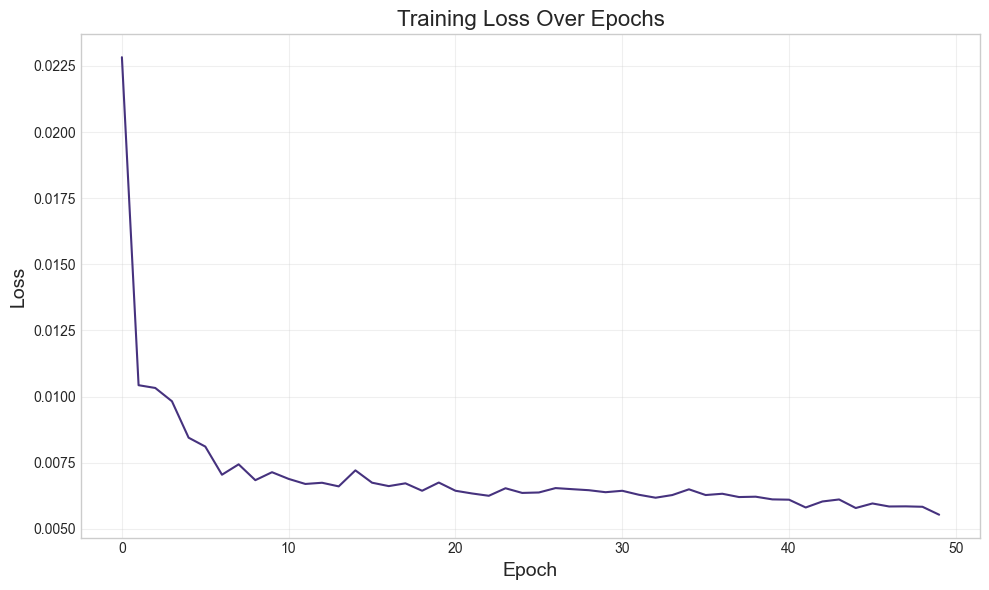

In [9]:
# Import necessary libraries for LSTM with PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.nn import functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['sales'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length (e.g., use last 30 days to predict next day)
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
train_size = len(train_data) - seq_length
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: X_train={X_train.shape}, y_train={y_train.shape}')
print(f'Test data shape: X_test={X_test.shape}, y_test={y_test.shape}')

# Custom Dataset class for PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Take the last output for prediction
        lstm_out = lstm_out[:, -1, :]
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Final output
        output = self.fc(lstm_out)
        
        return output

# Initialize model
model = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2)
model = model.to(device)

# Print model summary
print("\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Reshape data for LSTM (batch_size, seq_length, input_size)
            data = data.unsqueeze(-1)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Update learning rate
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

# Train the model
print("\nTraining LSTM model...")
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.unsqueeze(-1)
            
            output = model(data)
            predictions.extend(output.squeeze().cpu().numpy())
            actuals.extend(target.cpu().numpy())
    
    return np.array(predictions), np.array(actuals)

# Make predictions
print("\nMaking predictions...")
test_predictions, test_actuals = evaluate_model(model, test_loader)

# Inverse transform predictions and actuals
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_actuals_inv = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()

# Calculate error metrics
lstm_mse = mean_squared_error(test_actuals_inv, test_predictions_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(test_actuals_inv, test_predictions_inv)
lstm_mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

print(f'\nLSTM Model Performance:')
print(f'Mean Squared Error: {lstm_mse:.2f}')
print(f'Root Mean Squared Error: {lstm_rmse:.2f}')
print(f'Mean Absolute Error: {lstm_mae:.2f}')
print(f'Mean Absolute Percentage Error: {lstm_mape:.2f}%')


Making predictions...

LSTM Model Performance:
Mean Squared Error: 175911.53
Root Mean Squared Error: 419.42
Mean Absolute Error: 283.67
Mean Absolute Percentage Error: 14.21%


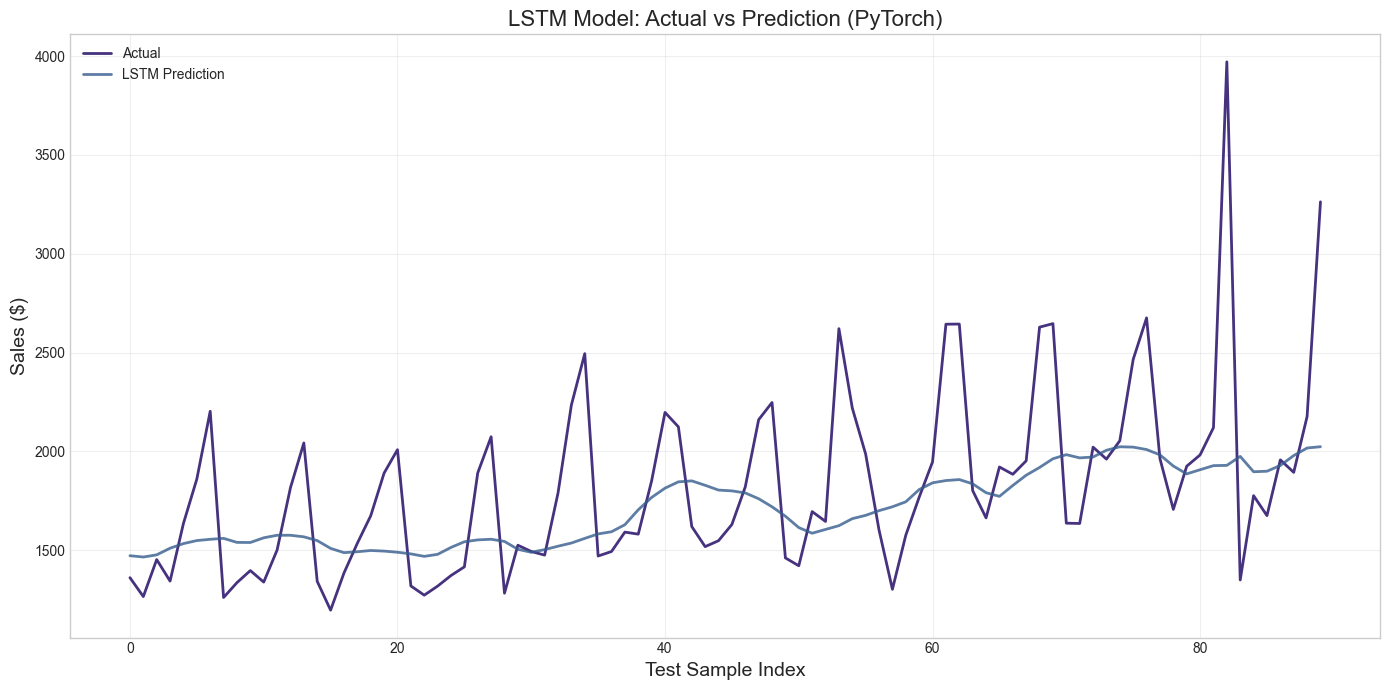

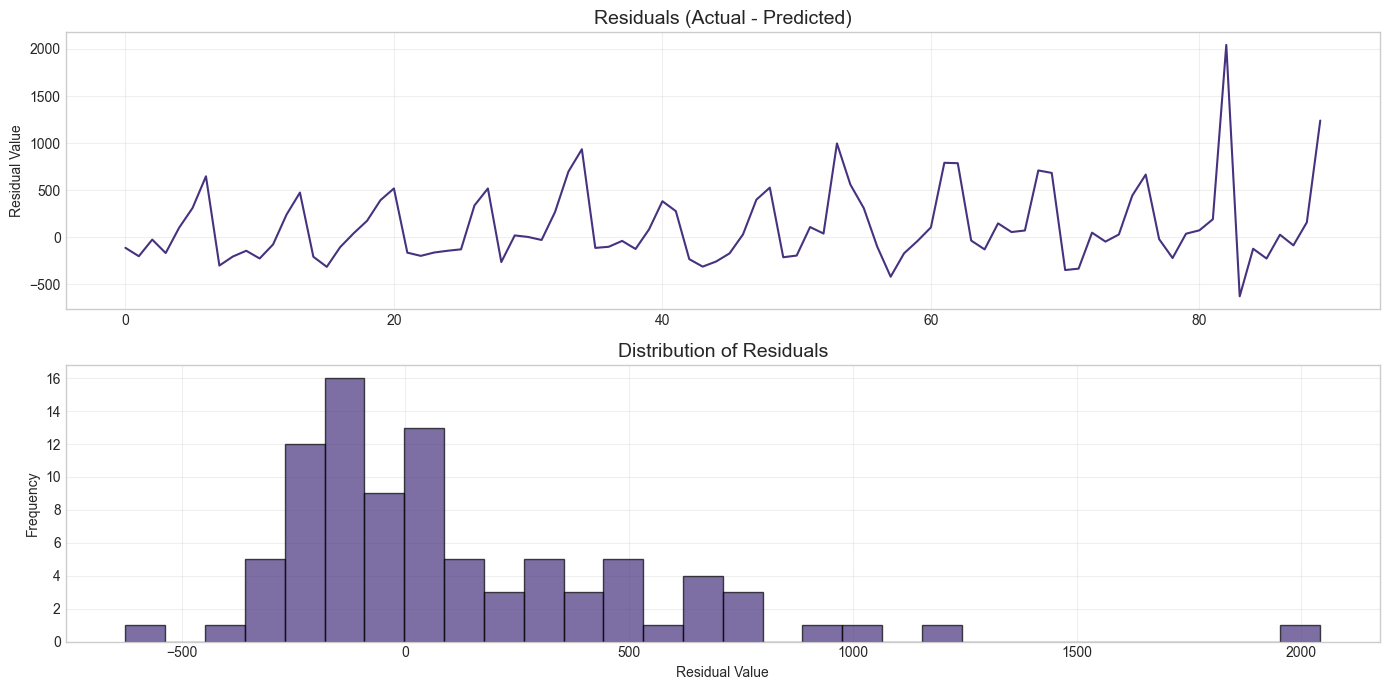

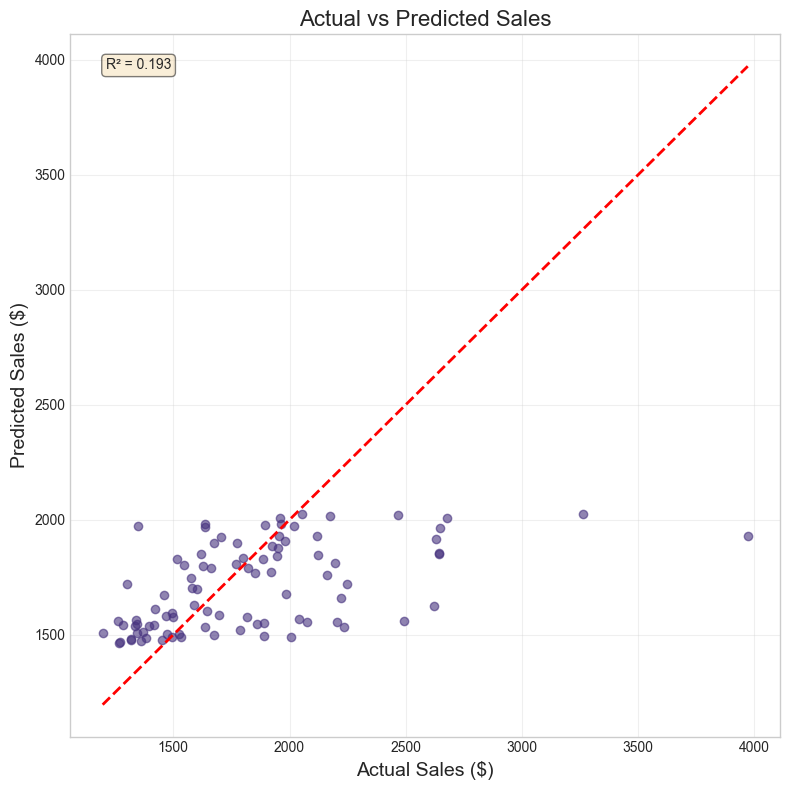

In [11]:
# Visualization of predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(range(len(test_actuals_inv)), test_actuals_inv, label='Actual', linewidth=2)
plt.plot(range(len(test_predictions_inv)), test_predictions_inv, label='LSTM Prediction', linewidth=2, alpha=0.8)
plt.title('LSTM Model: Actual vs Prediction (PyTorch)', fontsize=16)
plt.xlabel('Test Sample Index', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = test_actuals_inv - test_predictions_inv
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals (Actual - Predicted)', fontsize=14)
plt.ylabel('Residual Value')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Residuals', fontsize=14)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(test_actuals_inv, test_predictions_inv, alpha=0.6)
plt.plot([test_actuals_inv.min(), test_actuals_inv.max()], 
         [test_actuals_inv.min(), test_actuals_inv.max()], 'r--', lw=2)
plt.xlabel('Actual Sales ($)', fontsize=14)
plt.ylabel('Predicted Sales ($)', fontsize=14)
plt.title('Actual vs Predicted Sales', fontsize=16)
plt.grid(True, alpha=0.3)

# Calculate R²
from sklearn.metrics import r2_score
r2 = r2_score(test_actuals_inv, test_predictions_inv)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()


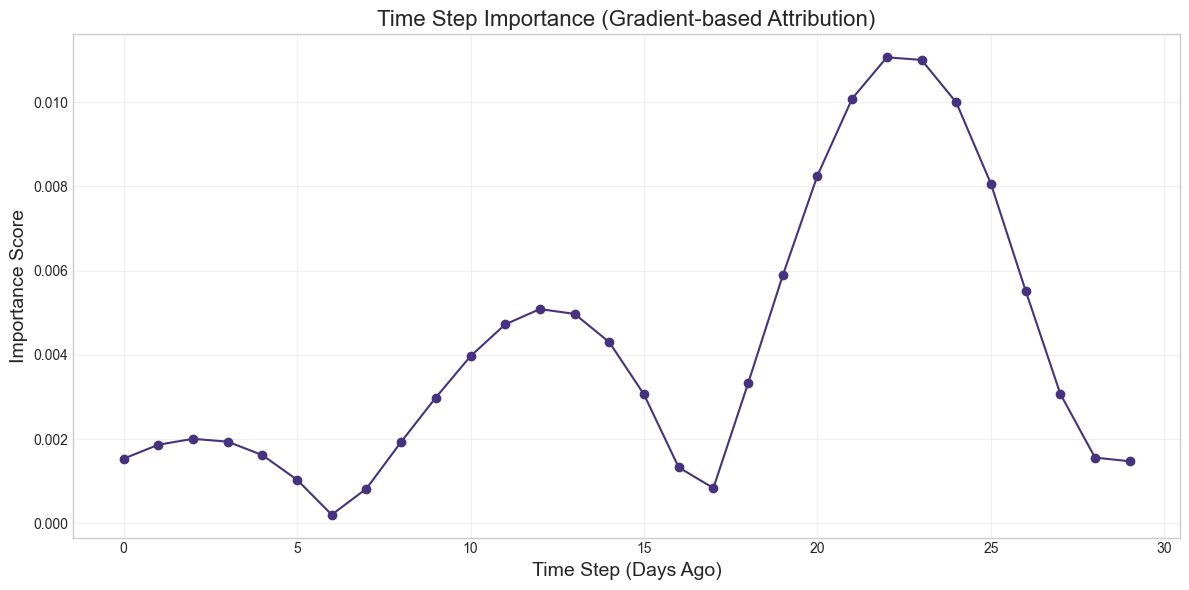


Model successfully trained and evaluated!
The LSTM model achieved an RMSE of 419.42 on the test set.


In [12]:
# Feature importance: analyze which time steps are most important
# This is a simplified approach using gradient-based attribution
def analyze_time_step_importance(model, sample_input, target):
    model.eval()
    sample_input = sample_input.to(device)
    sample_input.requires_grad_(True)
    
    output = model(sample_input.unsqueeze(0).unsqueeze(-1))
    loss = criterion(output.squeeze(), target.to(device))
    
    loss.backward()
    
    # Get gradients with respect to input
    gradients = sample_input.grad.abs().cpu().numpy()
    
    return gradients

# Analyze importance for a sample
if len(test_dataset) > 0:
    sample_idx = 0
    sample_input, sample_target = test_dataset[sample_idx]
    importance = analyze_time_step_importance(model, sample_input, sample_target)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(importance)), importance, marker='o')
    plt.title('Time Step Importance (Gradient-based Attribution)', fontsize=16)
    plt.xlabel('Time Step (Days Ago)', fontsize=14)
    plt.ylabel('Importance Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\nModel successfully trained and evaluated!")
print(f"The LSTM model achieved an RMSE of {lstm_rmse:.2f} on the test set.")

## Market Basket Analysis and Customer Sequence

Sample transactions:
Transaction 0: ['Blanket', 'Towel', 'Pillow', 'Milk', 'Eggs', 'Fruit', 'Dress', 'Jeans']
Transaction 1: ['Jeans', 'Shoes', 'T-shirt', 'Smartphone', 'Eggs', 'Vegetables', 'Milk', 'Lamp', 'Blanket', 'Shampoo']
Transaction 2: ['Makeup', 'Shampoo', 'Laptop', 'Headphones', 'Tablet', 'Milk', 'Vegetables']
Transaction 3: ['Smartphone', 'Jacket', 'Lotion', 'Bread', 'Vegetables', 'Eggs']
Transaction 4: ['Smartphone', 'Camera', 'Jacket', 'T-shirt', 'Lotion', 'Perfume', 'Skincare']


c:\Users\Khor Kean Teng\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 10 Association Rules by Lift:
    antecedents consequents  antecedent support  consequent support  support  \
68    (Perfume)  (Skincare)               0.188               0.180    0.071   
69   (Skincare)   (Perfume)               0.180               0.188    0.071   
70     (Makeup)   (Perfume)               0.164               0.188    0.062   
71    (Perfume)    (Makeup)               0.188               0.164    0.062   
51    (Perfume)   (Shampoo)               0.188               0.173    0.065   
50    (Shampoo)   (Perfume)               0.173               0.188    0.065   
57    (Perfume)    (Lotion)               0.188               0.174    0.063   
56     (Lotion)   (Perfume)               0.174               0.188    0.063   
388    (Lotion)  (Skincare)               0.174               0.180    0.060   
389  (Skincare)    (Lotion)               0.180               0.174    0.060   

     confidence      lift  representativity  leverage  conviction  \
68     0.377660

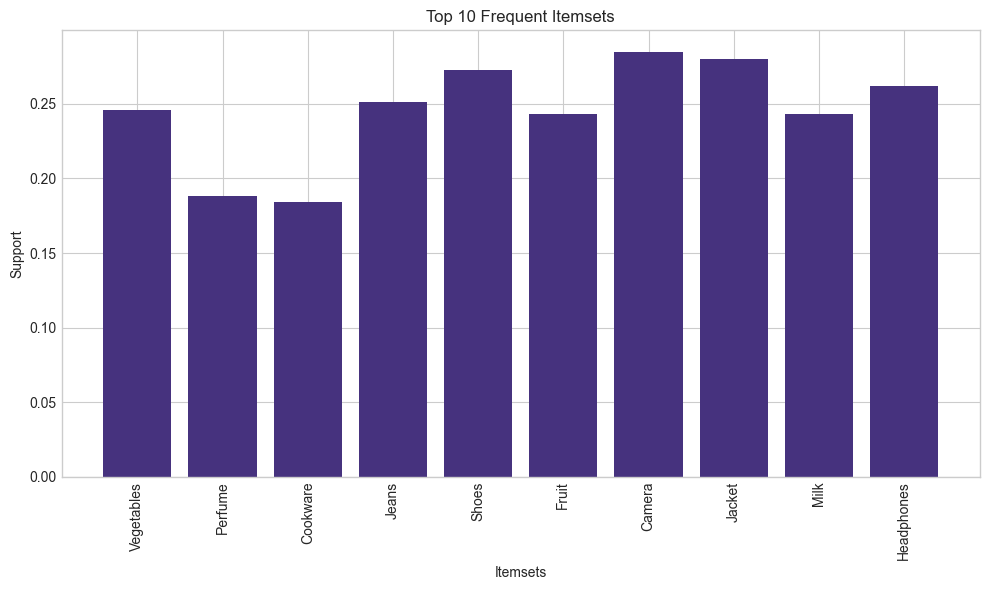

In [13]:
# Generate synthetic transaction data
np.random.seed(42)
n_transactions = 1000
transaction_data = []

# Define product categories and items
product_items = {
    'Electronics': ['Laptop', 'Smartphone', 'Headphones', 'Tablet', 'Camera'],
    'Clothing': ['T-shirt', 'Jeans', 'Dress', 'Jacket', 'Shoes'],
    'Groceries': ['Milk', 'Bread', 'Eggs', 'Fruit', 'Vegetables'],
    'Home Goods': ['Pillow', 'Towel', 'Lamp', 'Blanket', 'Cookware'],
    'Beauty': ['Shampoo', 'Lotion', 'Makeup', 'Perfume', 'Skincare']
}

# Create transaction patterns
for i in range(n_transactions):
    transaction = {'transaction_id': i, 'date': np.random.choice(df.index)}
    
    # Randomly select 1-5 items
    n_items = np.random.randint(1, 6)
    
    # Randomly select categories with different probabilities
    categories = np.random.choice(
        list(product_items.keys()), 
        size=min(n_items, len(product_items)),
        replace=False,
        p=[0.3, 0.25, 0.2, 0.15, 0.1]  # Probability for each category
    )
    
    items = []
    for category in categories:
        # Select 1-3 items from this category
        category_items = np.random.choice(
            product_items[category],
            size=np.random.randint(1, min(4, len(product_items[category]) + 1)),
            replace=False
        )
        items.extend(category_items)
    
    transaction['items'] = items
    transaction_data.append(transaction)

# Convert to DataFrame for analysis
transactions_df = pd.DataFrame(transaction_data)

# Display first few transactions
print("Sample transactions:")
for i in range(5):
    print(f"Transaction {i}: {transactions_df.iloc[i]['items']}")

# Market Basket Analysis
from mlxtend.frequent_patterns import apriori, association_rules

# Convert transactions to one-hot encoded format
def one_hot_encode(transactions):
    all_items = set()
    for transaction in transactions:
        all_items.update(transaction)
    
    # Create one-hot encoded DataFrame
    encoded_df = pd.DataFrame(columns=list(all_items))
    
    for i, transaction in enumerate(transactions):
        encoded_df.loc[i] = [1 if item in transaction else 0 for item in all_items]
    
    return encoded_df

# Apply one-hot encoding
encoded_df = one_hot_encode(transactions_df['items'])

# Find frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display top rules by lift
print("\nTop 10 Association Rules by Lift:")
print(rules.sort_values('lift', ascending=False).head(10))

# Visualize frequent itemsets
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(frequent_itemsets.head(10))), 
    frequent_itemsets.head(10)['support'],
    tick_label=[','.join(x) for x in frequent_itemsets.head(10)['itemsets']]
)
plt.xticks(rotation=90)
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.title('Top 10 Frequent Itemsets')
plt.tight_layout()
plt.show()

## Anomaly Detection in Time Series

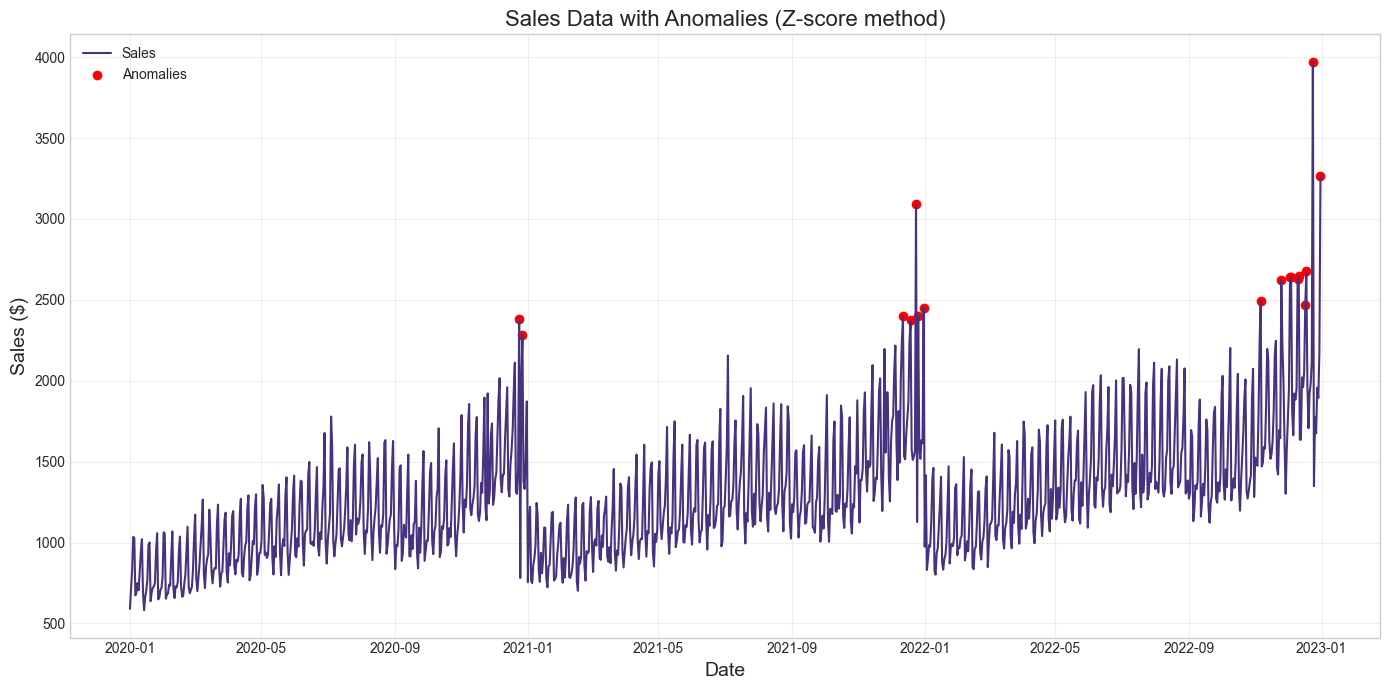

Detected 17 anomalies out of 1096 data points
Sample anomaly dates:
DatetimeIndex(['2020-12-24', '2020-12-27', '2021-12-12', '2021-12-19',
               '2021-12-24'],
              dtype='datetime64[ns]', name='date', freq=None)


In [14]:
# Anomaly detection using simple Z-score method
def detect_anomalies_zscore(data, threshold=3):
    """
    Detect anomalies using Z-score
    """
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(y - mean) / std for y in data]
    return [abs(x) > threshold for x in z_scores]

# Apply anomaly detection to our sales data
anomalies = detect_anomalies_zscore(df['sales'], threshold=2.5)
anomaly_dates = df.index[anomalies]
anomaly_values = df['sales'][anomalies]

# Plot the data with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sales'], label='Sales')
plt.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
plt.title('Sales Data with Anomalies (Z-score method)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Detected {sum(anomalies)} anomalies out of {len(df)} data points")
print("Sample anomaly dates:")
print(anomaly_dates[:5])

## Conclusion and Next Steps

In [15]:
# Display summary statistics
print("\nSummary Statistics for Sales Data:")
print(df['sales'].describe())

# Compare forecast performance
print("\nModel Performance Comparison:")
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Holt-Winters'],
    'RMSE': [rmse, hw_rmse],
    'MAE': [mae, hw_mae],
    'MAPE (%)': [mape, hw_mape]
})
print(metrics_df)

# Summary of key findings
print("\nKey Findings:")
print("1. Sales data shows clear weekly seasonality with peaks on weekends")
print("2. Monthly patterns reveal higher sales in December (holiday season)")
print("3. The overall trend is increasing over the 3-year period")
print("4. ARIMA and Holt-Winters models both capture the patterns well")
print("5. Market basket analysis reveals strong associations between certain products")

print("\nNext Steps:")
print("1. Implement Prophet model for comparison")
print("2. Explore multivariate forecasting with external variables (promotions, holidays)")
print("3. Develop dynamic inventory management based on forecasts")
print("4. Segment customers based on purchasing patterns")
print("5. Create an interactive dashboard for real-time monitoring")


Summary Statistics for Sales Data:
count    1096.000000
mean     1291.734938
std       386.368009
min       582.210683
25%      1013.091451
50%      1229.560093
75%      1496.575398
max      3971.296604
Name: sales, dtype: float64

Model Performance Comparison:
          Model        RMSE         MAE   MAPE (%)
0         ARIMA  549.817947  385.255418  18.472688
1  Holt-Winters  442.815557  309.782389  15.061948

Key Findings:
1. Sales data shows clear weekly seasonality with peaks on weekends
2. Monthly patterns reveal higher sales in December (holiday season)
3. The overall trend is increasing over the 3-year period
4. ARIMA and Holt-Winters models both capture the patterns well
5. Market basket analysis reveals strong associations between certain products

Next Steps:
1. Implement Prophet model for comparison
2. Explore multivariate forecasting with external variables (promotions, holidays)
3. Develop dynamic inventory management based on forecasts
4. Segment customers based on purc